In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


# PREPROCESSING DATA

In [ ]:
# Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv')
df = df[['Price']]
df['Price'] = df.Price.str.replace(',','').astype(float) # Format column Price to float
df = df.iloc[::-1] # Flip the column
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# SPLITTING DATA(7-2-1)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# ARIMA

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7655.215, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7657.006, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7657.015, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7654.291, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7658.881, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.436 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1806.3 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3
 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3
 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3 1806.3]


In [ ]:
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)


test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  89.63062710185518
Testing MAE:  71.49092664092665
Testing MAPE:  3.9727451310513744
Validation RMSE:  128.22052165342697
Validation MAE:  103.2696153846154
Validation MAPE:  5.270609797238504


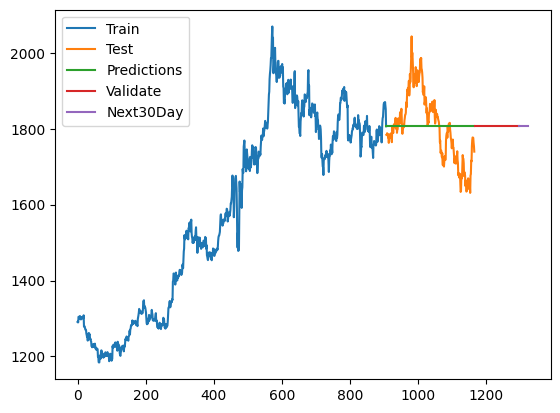

In [ ]:

# Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  907
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3826.146
Date:                Thu, 08 Jun 2023   AIC                           7654.291
Time:                        20:58:32   BIC                           7659.100
Sample:                             0   HQIC                          7656.128
                                - 907                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       272.6987      6.111     44.624      0.000     260.721     284.676
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):              1842.26
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               4.75   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6561.111, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6556.795, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6558.442, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6558.471, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6556.461, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6560.025, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.052 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1884.5 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5
 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5
 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5 1884.5]


In [ ]:
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  110.68163143616529
Testing MAE:  94.46069587628865
Testing MAPE:  5.358862109898867
Validation RMSE:  87.9269245731107
Validation MAE:  77.2263358778626
Validation MAPE:  4.037698208167587


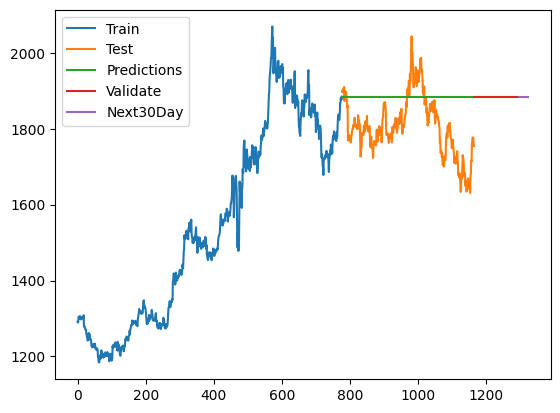

In [ ]:
# Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# SPLITTING DATA(5-3-2)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5439.153, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5440.891, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5440.910, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5439.082, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5442.657, Time=0.81 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.552 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1861.5 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5
 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5
 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5 1861.5]


In [ ]:
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  73.4372709033496
Testing MAE:  62.566237113402074
Testing MAPE:  3.464649632199253
Validation RMSE:  115.78595279818971
Validation MAE:  97.52615384615386
Validation MAPE:  5.440174123446247


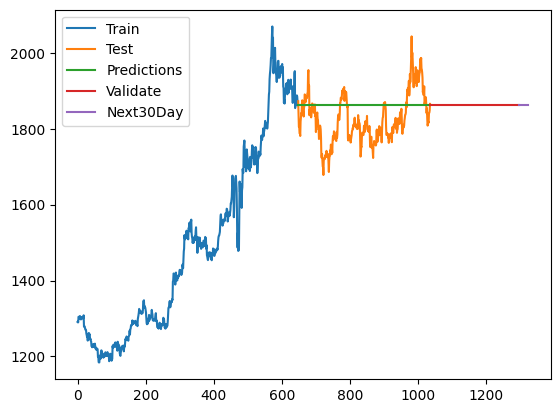

In [ ]:
# Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# EVALUATING MODEL

---
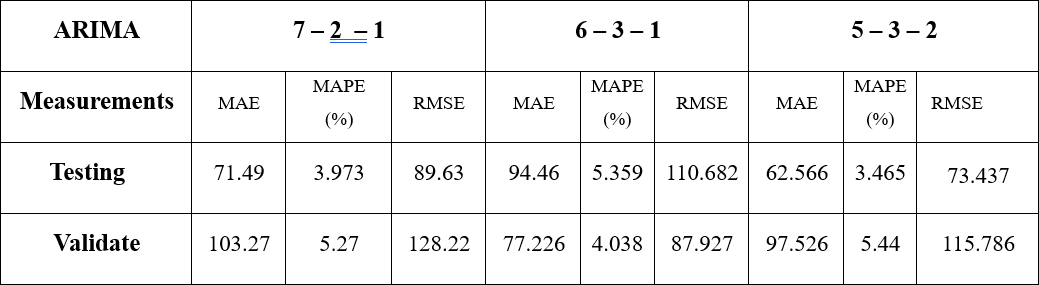